In [1]:
import sys
sys.path.append("..")

from vizutils import plot_comparison

## PBNN-8-8-8-8

### SILU


Final values (mean ± std):

PBNN (0, 4):
  RMSE: 1.0224 ± 0.0468
  NLPD: 1.4603 ± 0.0298
  COVERAGE: 0.9601 ± 0.0196

PBNN (1, 4):
  RMSE: 1.0923 ± 0.0626
  NLPD: 1.5345 ± 0.1003
  COVERAGE: 0.9241 ± 0.0224

PBNN (2, 4):
  RMSE: 1.1910 ± 0.0499
  NLPD: 1.7388 ± 0.0798
  COVERAGE: 0.8672 ± 0.0138

PBNN (3, 4):
  RMSE: 1.3290 ± 0.0606
  NLPD: 2.1543 ± 0.2017
  COVERAGE: 0.8234 ± 0.0193

Full BNN:
  RMSE: 0.9024 ± 0.0473
  NLPD: 1.3379 ± 0.0249
  COVERAGE: 0.9586 ± 0.0303


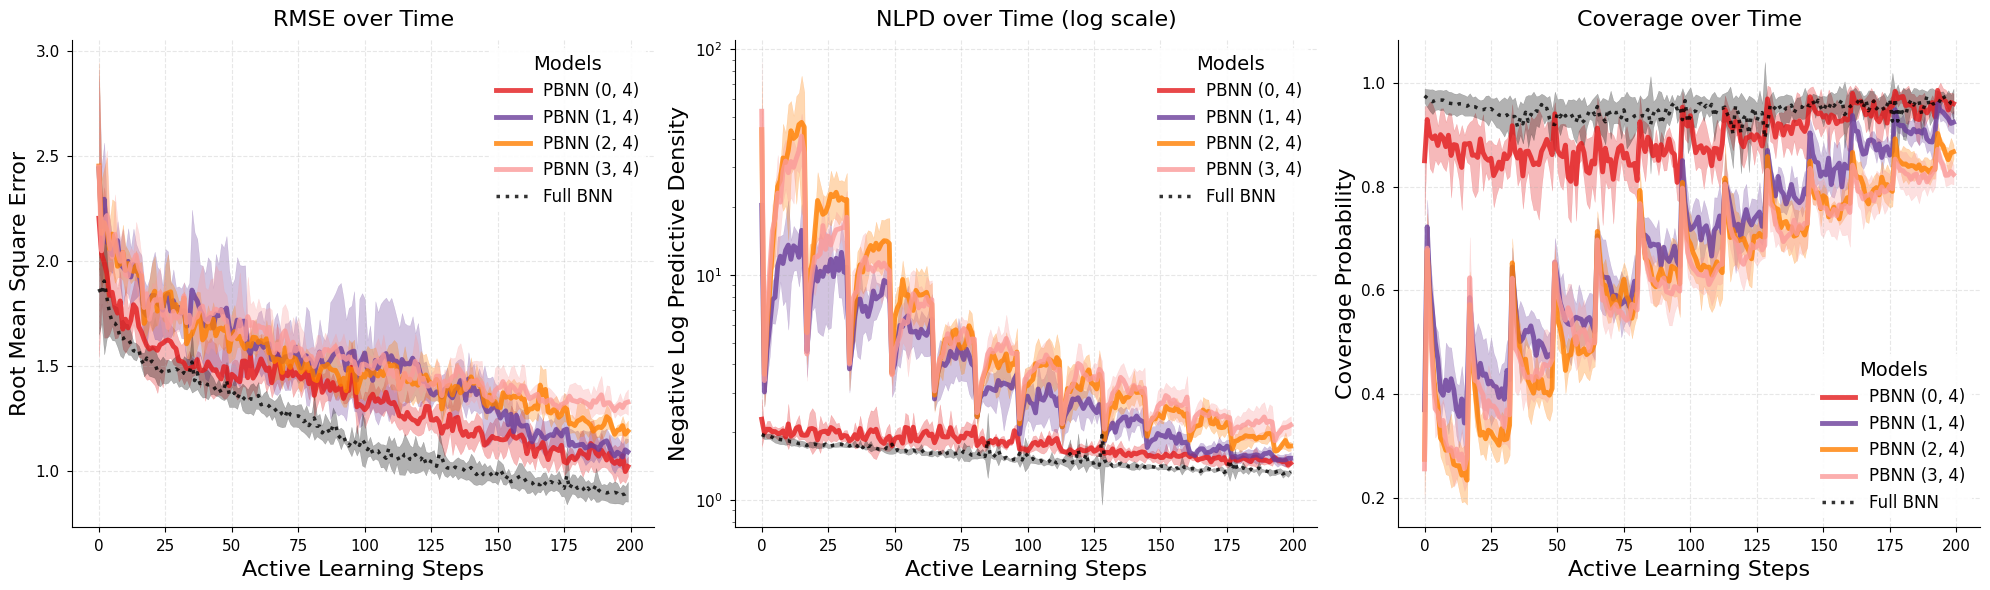

In [3]:
pbnn_files = [
    'results/pbnn8888/freesolv_probdense0-dense4_steps200_epochs2000_lr0.005_20241207_202629.pkl',
    'results/pbnn8888/freesolv_probdense1-dense4_steps200_epochs2000_lr0.005_20241208_001700.pkl',
    'results/pbnn8888/freesolv_probdense2-dense4_steps200_epochs2000_lr0.005_20241208_031223.pkl',
    'results/pbnn8888/freesolv_probdense3-dense4_steps200_epochs2000_lr0.005_20241207_161442.pkl'   
]

bnn_file = 'results/bnn8888/freesolv_steps200_20241212_055947.pkl'

plot_comparison(
    pbnn_files=pbnn_files,
    bnn_file=bnn_file,
    save_path='comparison_plot-pbnn8888-silu.png'
);


Final values (mean ± std):

PBNN (Dense 3, Dense 4):
  RMSE: 1.0771 ± 0.0278
  NLPD: 2.0736 ± 0.1302
  COVERAGE: 0.7737 ± 0.0271

PBNN (Dense 2, Dense 3, Dense 4):
  RMSE: 1.0325 ± 0.0613
  NLPD: 1.8452 ± 0.1967
  COVERAGE: 0.7898 ± 0.0306

PBNN (Dense 1, Dense 4):
  RMSE: 1.0156 ± 0.0696
  NLPD: 1.4897 ± 0.1472
  COVERAGE: 0.9002 ± 0.0502


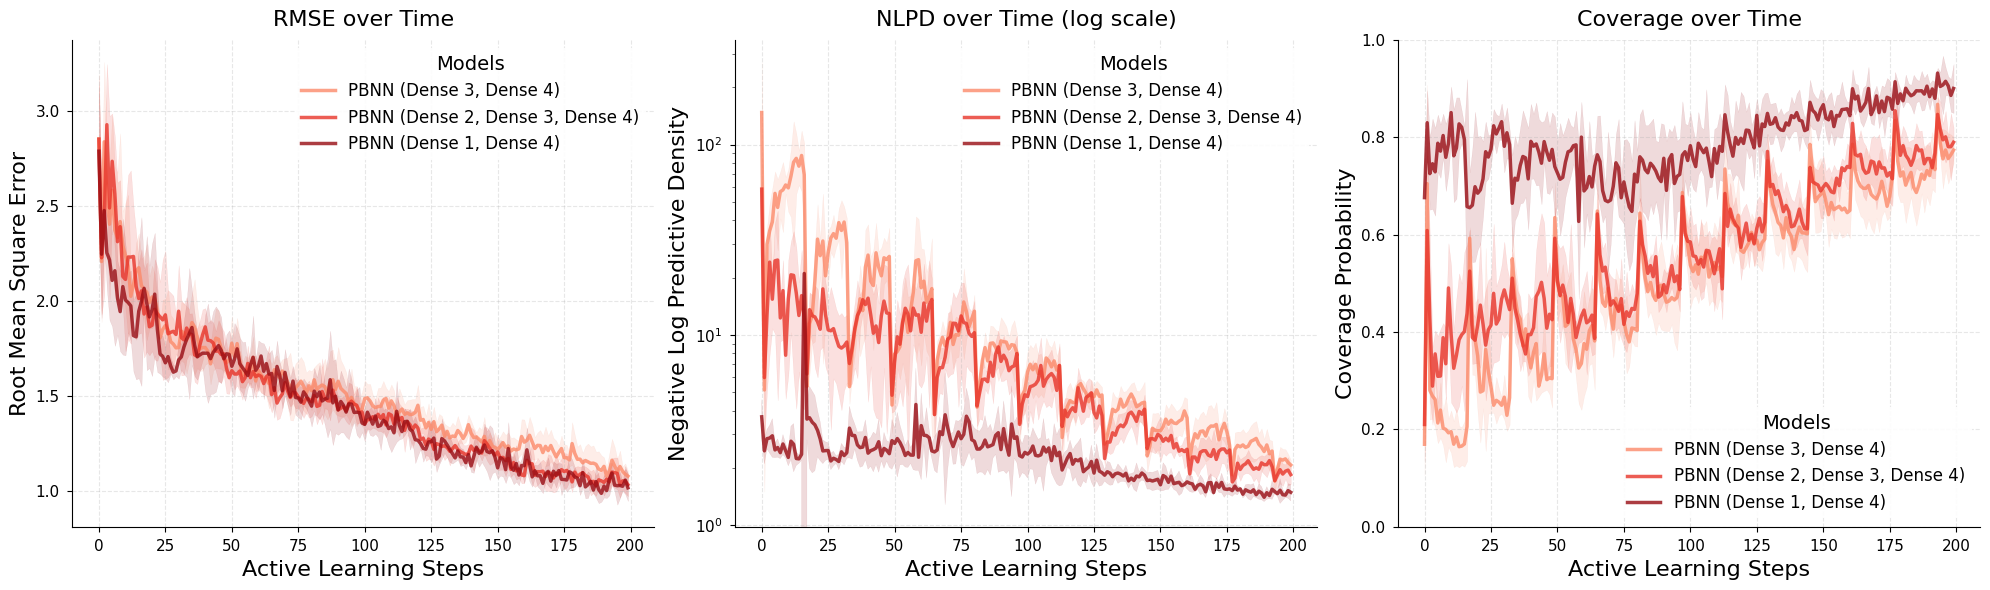

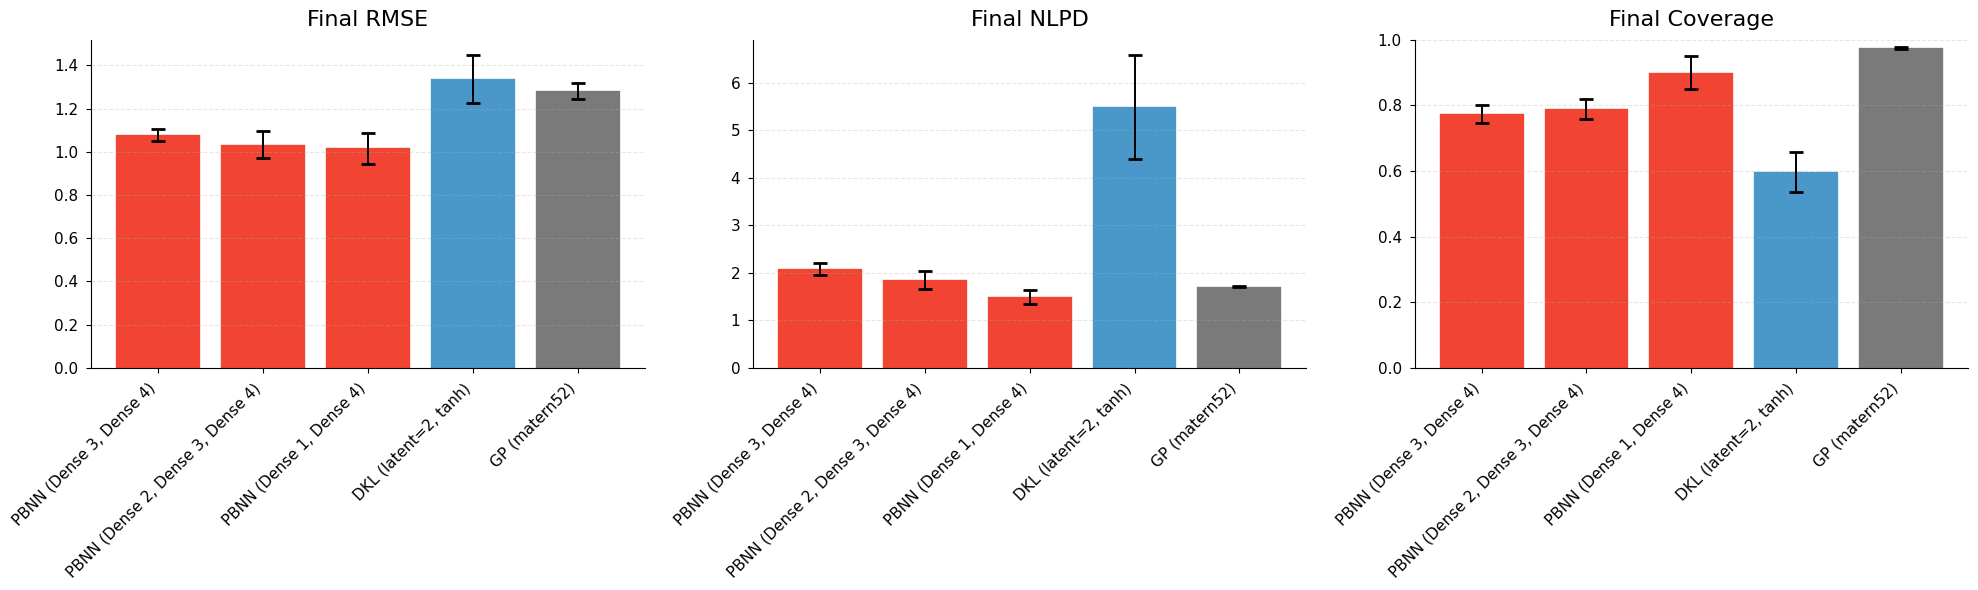

In [15]:
pbnn_files = [
    'results/freesolv_probdense3-dense4_steps200_epochs2000_lr0.005_20241127_220442.pkl',
    'results/freesolv_probdense2-dense3-dense4_steps200_epochs2000_lr0.005_20241128_041002.pkl',
    'results/freesolv_probdense1-dense4_steps200_epochs2000_lr0.005_20241130_021537.pkl',
]

dkl_files = [
    'results/dkl/freesolv_dkl_comparison_latent2_tanh_20241205_145809.pkl',
]

gp_files = [
    'results/gp/freesolv_gp_comparison_kernelmatern52_20241205_174936.pkl'
]

# Create both visualizations
plot_comparison(
    pbnn_files=pbnn_files,
    save_path='comparison_plot_tanh.png'
);

plot_final_results(
    pbnn_files=pbnn_files,
    dkl_files=dkl_files,
    gp_files=gp_files,
    save_path='final_results_bars_tanh.png'
);


Final values (mean ± std):

PBNN (Dense 3, Dense 4):
  RMSE: 1.3039 ± 0.0576
  NLPD: 2.4725 ± 0.2617
  COVERAGE: 0.7596 ± 0.0267

PBNN (Dense 2, Dense 3, Dense 4):
  RMSE: 1.3048 ± 0.0348
  NLPD: 2.5056 ± 0.2052
  COVERAGE: 0.7659 ± 0.0212

PBNN (Dense 1, Dense 4):
  RMSE: 1.0635 ± 0.0384
  NLPD: 1.5478 ± 0.0745
  COVERAGE: 0.8832 ± 0.0167


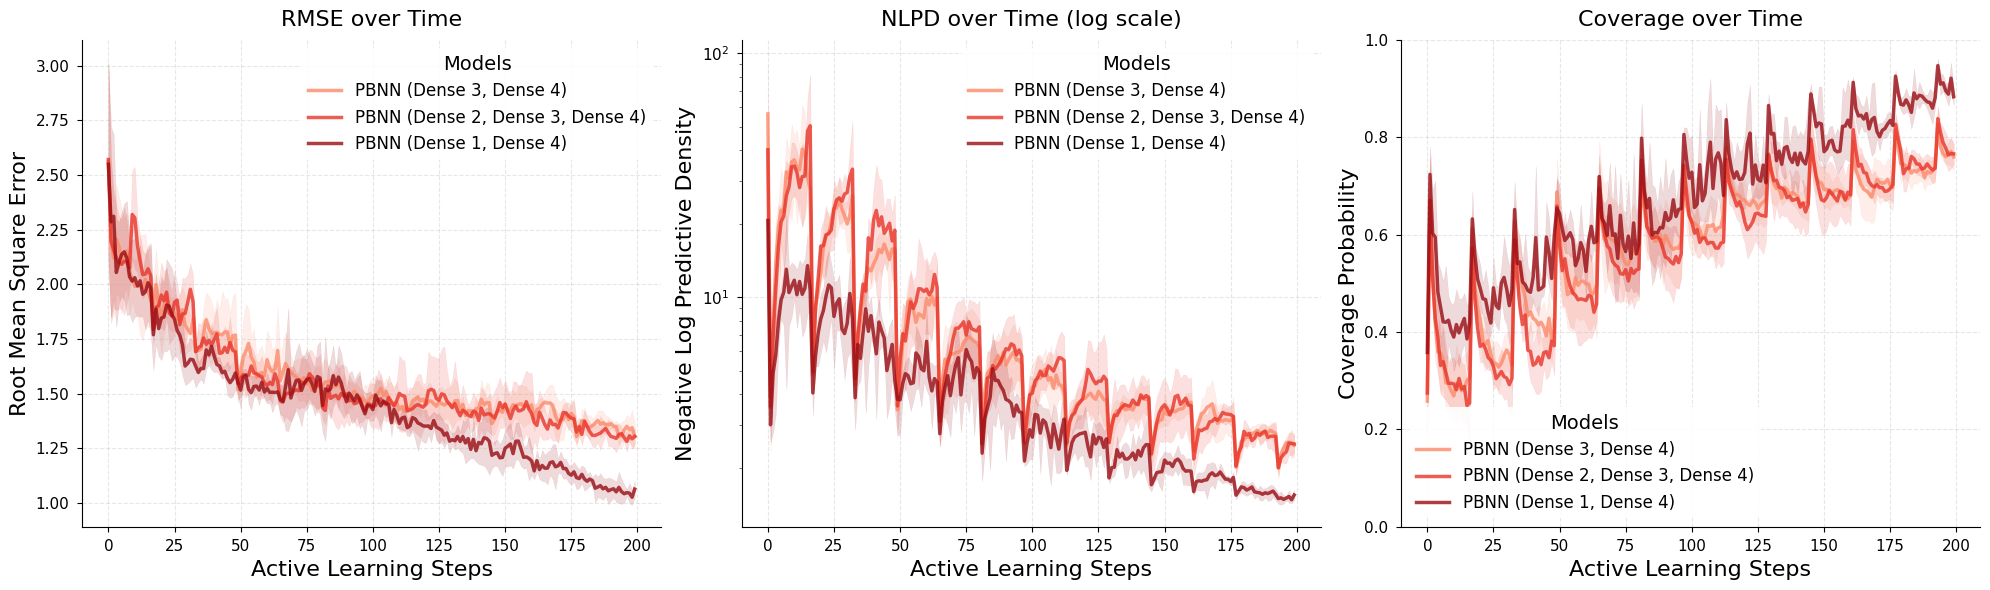

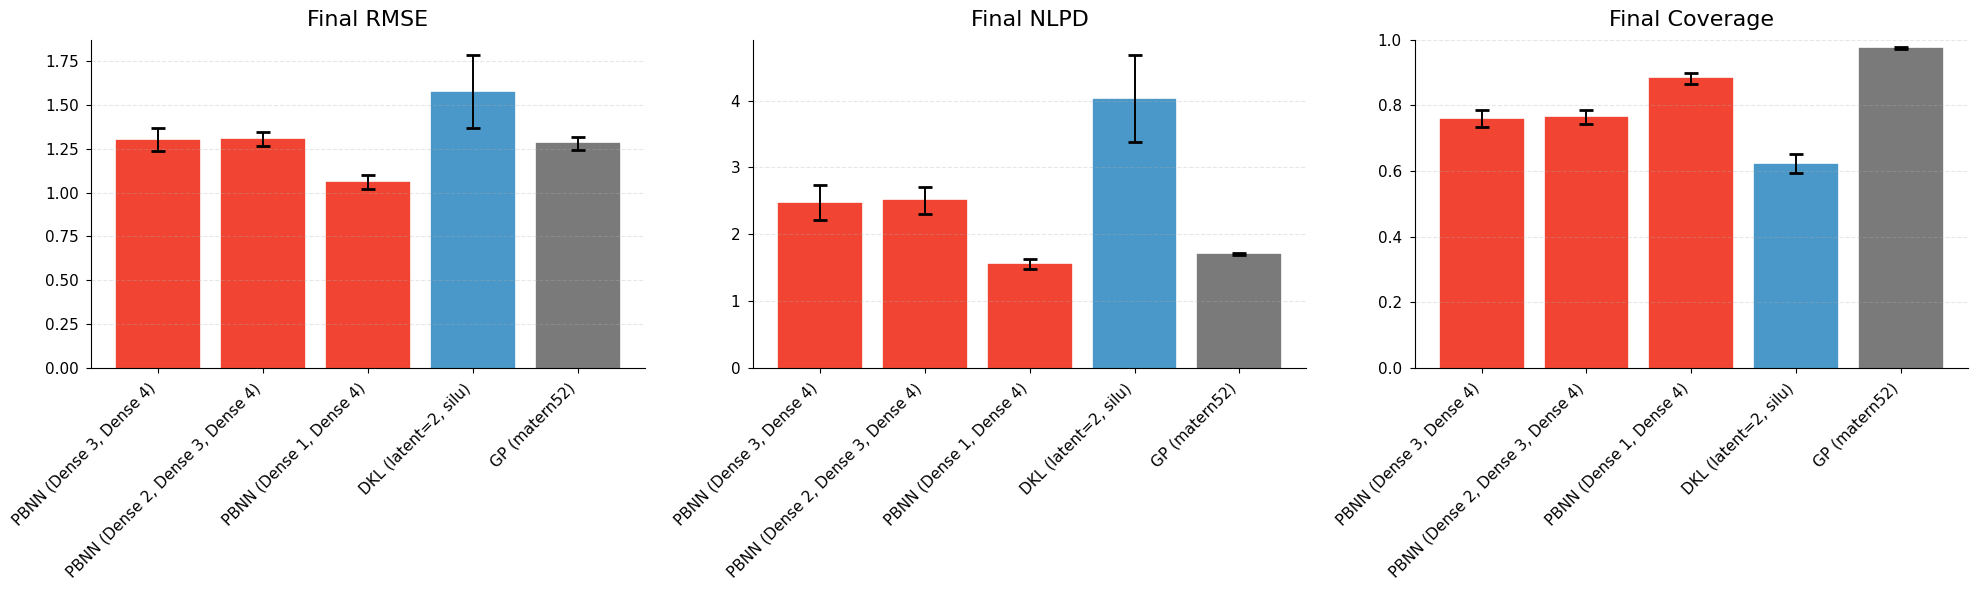

In [16]:
pbnn_files = [
    'results/freesolv_probdense3-dense4_steps200_epochs2000_lr0.005_20241203_171623.pkl',
    'results/freesolv_probdense2-dense3-dense4_steps200_epochs2000_lr0.005_20241203_142007.pkl',
    'results/freesolv_probdense1-dense4_steps200_epochs2000_lr0.005_20241203_075738.pkl',
]

dkl_files = [
    'results/dkl/freesolv_dkl_comparison_latent2_silu_20241205_155114.pkl',
]

gp_files = [
    'results/gp/freesolv_gp_comparison_kernelmatern52_20241205_174936.pkl'
]

# Create both visualizations
plot_comparison(
    pbnn_files=pbnn_files,
    save_path='comparison_plot_silu.png'
);

plot_final_results(
    pbnn_files=pbnn_files,
    dkl_files=dkl_files,
    gp_files=gp_files,
    save_path='final_results_bars_silu.png'
);